**How to use this notebook**

The function `plot_variance_decomposition` can be used to look at the variance decomposition of several metrics for a specific coordinate or over a chosen region. Run the function as follows:
1. Select a metric, formatted as a string. You can choose among: 
    * Annual average temperature: `avg_tas`
    * Annual total precipitation: `tot_pr`
    * Annual maximum of daily maximum temperature: `max_tasmax`
    * Annual maximum of daily precipitation: `max_pr`
    * Annual number of extremely hot days: `hot_days`
    * Annual number of dry days: `dry_days`
    * Annual number of extremely wet days: `wet_days`
2. Select a region, formatted as a list of ints or floats. You can choose to look at:
    * A single coordinate: `[lat, lon]`
    * An extended region defined by bounding box: `[lat_min, lat_max, lon_min, lon_max]`

Note that the latitude coordinate must lie within (-60, 90) and the longitude coordinate within (-180, 180). Gridpoints over the ocean will return null results.

\
**Dependencies**
* `numpy`
* `xarray`
* `matplotlib`

\
**Additional notes**
* Extremely hot days are defined as when daily maximum temperature exceeds the local 99th percentile calculated over 1980-2014 from GMFD
* Dry days are defined as when daily precipitation is less than 1mm
* Extremely wet days are defined as when daily precipitation exceeds the local 99th percentile calculated over 1980-2014 from GMFD
* Note that for extended regions, the variance decomposition is calculated at each gridpoint and then the plot shows the averaged results. This is different from first averaging the metric over the region and then calculating the variance decomposition!
* Variance decomposition is calculated following the main results in [Lafferty & Sriver (2023)](https://doi.org/10.22541/essoar.168286894.44910061/v1)

### Function definition

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr


def plot_variance_decomposition(
    metric,
    region,
):
    """
    Region can either be a specific [lat, lon], a bounding [lat_min, lat_max, lon_min, lon_max].
    """
    # Read
    if metric not in ["avg_tas", "tot_pr", "max_tasmax", "max_pr", "hot_days", "dry_days", "wet_days"]:
        print("Metric not valid!")
        return None
    else:
        ds = xr.open_dataset(metric + ".nc")[metric]

    # Select region
    if type(region) != list:
        print("Region not valid!")
        return None
    else:
        region_float = [float(r) for r in region]
        if len(region_float) == 2:
            ds_masked = ds.sel(lat=region_float[0], lon=region_float[1], method="nearest")
        elif len(region_float) == 4:
            ds_masked = ds.sel(lat=slice(region_float[0], region_float[1]), lon=slice(region_float[2], region_float[3]))
            ds_masked = ds_masked.mean(dim=["lat", "lon"], skipna=True)
        else:
            print("Region not valid!")
            return None

    # Construct plotting dict
    uncert_dict = {
        "Scenario": ds_masked.sel(uncertainty="scenario_hs09").to_numpy().flatten(),
        "Model": ds_masked.sel(uncertainty="model").to_numpy().flatten(),
        "Downscaling": ds_masked.sel(uncertainty="ensemble").to_numpy().flatten(),
        "Variability": ds_masked.sel(uncertainty="variability").to_numpy().flatten(),
    }

    # Make plot
    fig, ax = plt.subplots()

    ax.stackplot(
        np.arange(2015, 2101),
        uncert_dict.values(),
        labels=uncert_dict.keys(),
        alpha=1,
        colors=["#00CC89", "#6869B3", "#CC883C", "#FFFF99"],
        edgecolor="white",
        lw=1.5,
    )

    # Plot details
    ax.set_xlim([2020, 2095])
    ax.set_xticks([2030, 2050, 2070, 2090])
    ax.set_ylim([0, 100])
    ax.set_ylabel("Fraction of total variance (%)")
    ax.legend(ncol=2, loc="upper left")

    # Title
    if len(region_float) == 2:
        ax.set_title("Coordinate: {:.2f}N, {:.2f}E".format(region_float[0], region_float[1]))
    elif len(region_float) == 4:
        ax.set_title(
            "Region: {:.2f}N < lat. < {:.2f}N, {:.2f}E < lon. < {:.2f}E".format(
                region_float[0], region_float[1], region_float[2], region_float[3]
            )
        )

    fig.suptitle(metric, fontweight="bold")
    plt.show()

### Plot

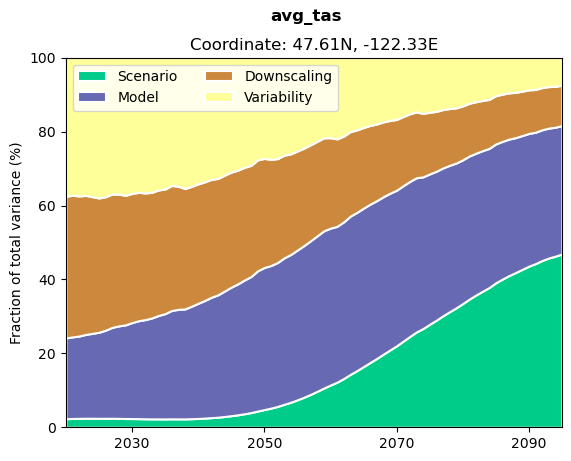

In [2]:
# Example: Seattle average temperature, should match Fig. 1e in paper
plot_variance_decomposition("avg_tas", [47.609722, -122.333056])